# Programming with RDDs

#### Links

* https://spark.apache.org/docs/1.6.0/programming-guide.html#resilient-distributed-datasets-rdds
* https://spark.apache.org/docs/1.1.1/api/python/pyspark.rdd.RDD-class.html

In [1]:
%matplotlib inline
%config InlineBackend.figure_format ='retina'

import os
import sys
import glob
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import sys
sys.path.append('./')

from utils import *


os.environ["PYSPARK_PYTHON"] = "/usr/local/bin/python3.5"

In [2]:
!spark-submit --version

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /___/ .__/\_,_/_/ /_/\_\   version 1.6.0
      /_/
                        
Type --help for more information.


## Запускаем Spark

In [3]:
import pyspark
from pyspark.conf import SparkConf
from pyspark.sql import SQLContext


conf = SparkConf()
conf.setMaster("yarn-client")
# conf.setMaster("local[*]")
conf.setAppName("spark_examples")
conf.set("spark.executor.memory", "2g")
conf.set("spark.core.connection.ack.wait.timeout", "1200")

conf.set("spark.executor.instances", "2")  # кол-во  executor'ов
conf.set("spark.executor.cores", "2")  # сколько ядер у каждого

sc = pyspark.SparkContext(conf = conf)
sc.addPyFile('./utils.py')
sqlContext = SQLContext(sc)

## Работа с hdfs

Утилитой командной строки -- `hdfs` (https://hadoop.apache.org/docs/current/hadoop-project-dist/hadoop-common/FileSystemShell.html)

Полезные команды:
* `hdfs dfs -ls [<path>]`
* `hdfs dfs -rm <path>`
* `hdfs dfs -mv <src> <dst>`
* `hdfs dfs -copyToLocal <src> <dst local>`
* `hdfs dfs -copyFromLocal <src local> <dst>`


### Копирование данных

Прежде чем начать работать с самим данными их нужно сохранить в hdfs.

1. Запустите terminal через Jupyter
2. `hdfs dfs -copyFromLocal data .`


Проверяем, что все данные на месте

In [4]:
!hdfs dfs -copyFromLocal data .

In [5]:
!hdfs dfs -ls data/ml-25m/

Found 9 items
-rw-r--r--   1 root supergroup      10460 2021-02-15 19:02 data/ml-25m/README.txt
-rw-r--r--   1 root supergroup  435164157 2021-02-15 19:02 data/ml-25m/genome-scores.csv
-rw-r--r--   1 root supergroup      18103 2021-02-15 19:02 data/ml-25m/genome-tags.csv
-rw-r--r--   1 root supergroup    1368578 2021-02-15 19:02 data/ml-25m/links.csv
-rw-r--r--   1 root supergroup      12022 2021-02-15 19:02 data/ml-25m/ml-25m-README.htm
-rw-r--r--   1 root supergroup    3038099 2021-02-15 19:02 data/ml-25m/movies.csv
-rw-r--r--   1 root supergroup  678260987 2021-02-15 19:02 data/ml-25m/ratings.csv
-rw-r--r--   1 root supergroup   38810332 2021-02-15 19:02 data/ml-25m/tags.csv
-rw-r--r--   1 root supergroup  404281742 2021-02-15 19:02 data/ml-25m/tmdb.json


### Чтение данных

*Замечание*: Файл `ml-25m-README.htm` содержит описание данных

In [6]:
DATA_PATH = 'data/ml-25m'

RATINGS_PATH = os.path.join(DATA_PATH, 'ratings.csv')
MOVIES_PATH = os.path.join(DATA_PATH, 'movies.csv')
TAGS_PATH = os.path.join(DATA_PATH, 'tags.csv')

In [7]:
ratings = sc.textFile(RATINGS_PATH)

In [8]:
%%time
ratings.take(5)

CPU times: user 2.31 ms, sys: 6.45 ms, total: 8.76 ms
Wall time: 2.04 s


['userId,movieId,rating,timestamp',
 '1,296,5.0,1147880044',
 '1,306,3.5,1147868817',
 '1,307,5.0,1147868828',
 '1,665,5.0,1147878820']

In [9]:
ratings.getNumPartitions()

5

In [10]:
ratings = ratings \
    .map(lambda s: s.split(',')) \
    .filter(lambda arr: arr[0].isdigit()) \
    .map(lambda arr: Rating(user_id=int(arr[0]), 
                            movie_id=int(arr[1]), 
                            rating=float(arr[2]), 
                            timestamp=int(arr[3])))

In [11]:
ratings.count()

25000095

Количество пользователей

In [12]:
%%time

ratings \
    .map(lambda r: r.user_id)\
    .distinct()\
    .count()

CPU times: user 15.9 ms, sys: 13.6 ms, total: 29.5 ms
Wall time: 1min 21s


162541

Сохраним датасет в память

In [13]:
ratings = ratings.persist()

In [14]:
%%time

ratings \
    .map(lambda r: r.user_id)\
    .distinct()\
    .count()

CPU times: user 35 ms, sys: 5.15 ms, total: 40.2 ms
Wall time: 2min 24s


162541

Количество фильмов

In [15]:
%%time

ratings \
    .map(lambda r: r.movie_id)\
    .distinct()\
    .count()

CPU times: user 38.3 ms, sys: 31 ms, total: 69.3 ms
Wall time: 39.9 s


59047

## Упражнения

### Фильмы с наибольшим средним рейтингом

Найти 10 фильмов с наибольшим средним рейтингом. Вывести их названия и средний рейтинг

In [92]:
movies = sc.textFile(MOVIES_PATH)
movies.take(5)

['movieId,title,genres',
 '1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy',
 '2,Jumanji (1995),Adventure|Children|Fantasy',
 '3,Grumpier Old Men (1995),Comedy|Romance',
 '4,Waiting to Exhale (1995),Comedy|Drama|Romance']

In [93]:
movies = movies \
    .map(lambda s: s.split(',')[:2]) \
    .filter(lambda arr: arr[0].isdigit()) \
    .keyBy(lambda arr: int(arr[0]))

movie_avg_rating = ratings \
    .map(lambda r: (r.movie_id, (r.rating, 1))) \
    .reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1])) \
    .mapValues(lambda ratings: ratings[0] / ratings[1])

movie_avg_rating \
    .join(movies) \
    .sortBy(lambda key_value: key_value[1][0], ascending=False)\
    .take(10)

[(196631, (5.0, ['196631', 'Red Is the Color of (2007)'])),
 (131188, (5.0, ['131188', 'A Man To Remember (1938)'])),
 (179621, (5.0, ['179621', 'Frau Holle (2008)'])),
 (207642, (5.0, ['207642', 'Kabir Singh (2019)'])),
 (164620, (5.0, ['164620', 'Zig Zag Story (1983)'])),
 (148254, (5.0, ['148254', 'A Dark Place Inside'])),
 (181175, (5.0, ['181175', 'War Requiem (1989)'])),
 (115795, (5.0, ['115795', 'Bronx Obama (2014)'])),
 (83161, (5.0, ['83161', 'Deadly Delicious (Shuang Shi Ji) (2008)'])),
 (165285, (5.0, ['165285', 'Homeless for the Holidays (2009)']))]

Сохраните `rdd`, состоящий из строк вида `<movie_id>,<average_rating>` на hdfs в виде текстового файла

In [ ]:
movie_avg_rating\
    .repartition(10) \
    .saveAsTextFile(os.path.join(DATA_PATH, 'movie_avg_rating'))

In [20]:
! hdfs dfs -ls data/ml-25m/movie_avg_rating

Found 11 items
-rw-r--r--   1 root supergroup          0 2021-02-07 20:40 data/ml-25m/movie_avg_rating/_SUCCESS
-rw-r--r--   1 root supergroup      59125 2021-02-07 20:40 data/ml-25m/movie_avg_rating/part-00000
-rw-r--r--   1 root supergroup     112200 2021-02-07 20:40 data/ml-25m/movie_avg_rating/part-00001
-rw-r--r--   1 root supergroup     131273 2021-02-07 20:40 data/ml-25m/movie_avg_rating/part-00002
-rw-r--r--   1 root supergroup     114154 2021-02-07 20:40 data/ml-25m/movie_avg_rating/part-00003
-rw-r--r--   1 root supergroup     133702 2021-02-07 20:40 data/ml-25m/movie_avg_rating/part-00004
-rw-r--r--   1 root supergroup     117718 2021-02-07 20:40 data/ml-25m/movie_avg_rating/part-00005
-rw-r--r--   1 root supergroup     143222 2021-02-07 20:40 data/ml-25m/movie_avg_rating/part-00006
-rw-r--r--   1 root supergroup     132134 2021-02-07 20:40 data/ml-25m/movie_avg_rating/part-00007
-rw-r--r--   1 root supergroup     167806 2021-02-07 20:40 data/ml-25m/movie_avg_rating/part-000

### Популярность тэгов

Найти 20 наиболее популярных тэгов

In [19]:
tags = sc.textFile(TAGS_PATH)
tags.take(5)

['userId,movieId,tag,timestamp',
 '3,260,classic,1439472355',
 '3,260,sci-fi,1439472256',
 '4,1732,dark comedy,1573943598',
 '4,1732,great dialogue,1573943604']

In [20]:
tags_count = tags\
    .map(lambda s: (s.split(',')[2], 1))\
    .reduceByKey(lambda a, b: a + b)\
    .collect()

len(tags_count)

73016

In [21]:
tags_count = sorted(tags_count, key=lambda tag_count: tag_count[1], reverse=True)

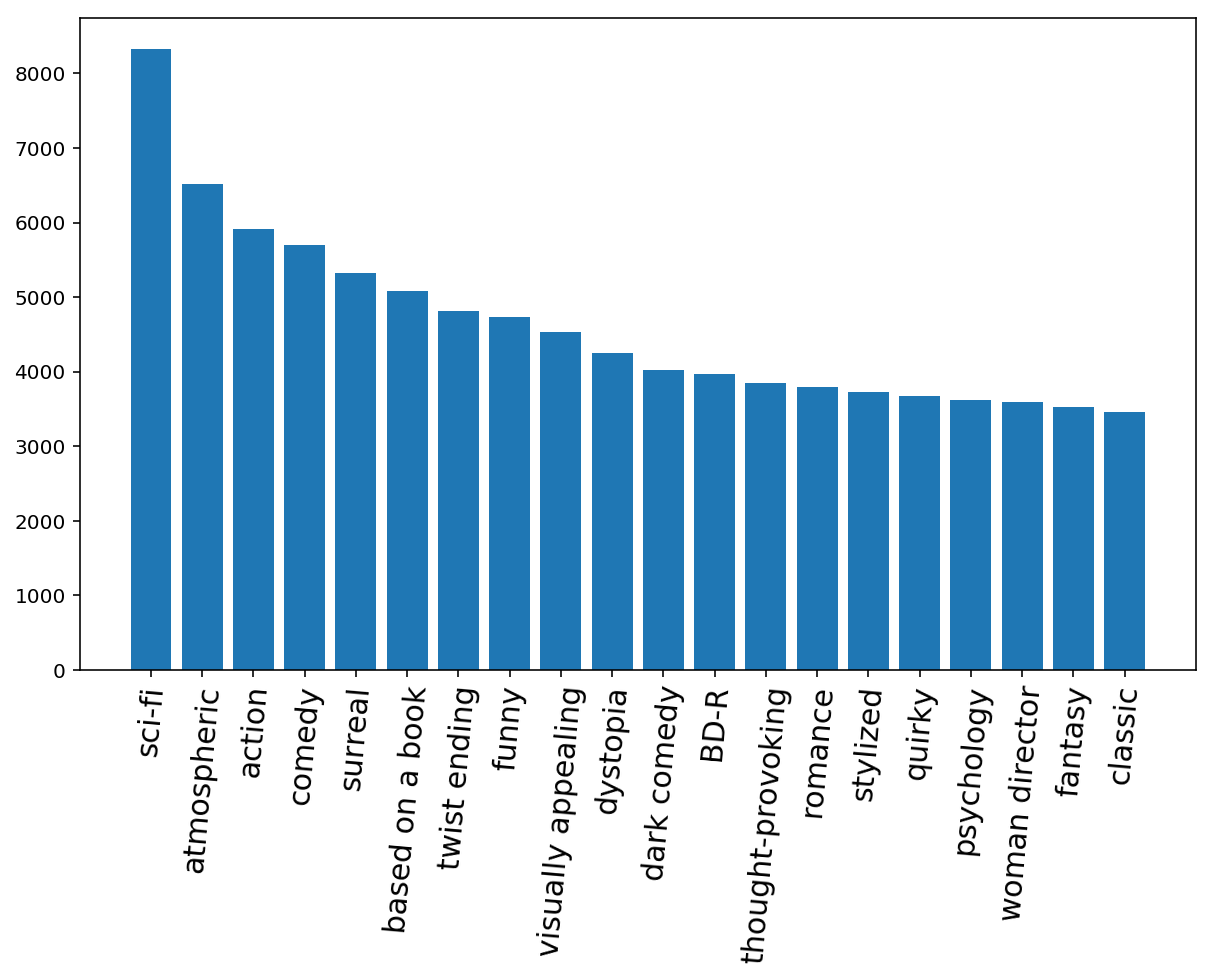

In [22]:
keys, values = zip(*tags_count[:20])

f, ax = plt.subplots(figsize=(10, 6))
plt.xticks(rotation=85, fontsize=15)
plt.bar(keys, values, align="center")
plt.show()

### Фильмы с наибольшим числом оценок

Найти 10 фильмов с наибольшим числом оценок. Вывести их названия и число оценок

In [42]:
ratings_cnt = ratings \
                .map(lambda r: (r.movie_id, 1)) \
                .reduceByKey(lambda a, b: a + b) \
                .join(movies) \
                .sortBy(lambda k: k[1], ascending=False)

ratings_cnt = [(movie[1][1][1], movie[1][0])  for movie in ratings_cnt.take(10)]
ratings_cnt

[('Forrest Gump (1994)', 81491),
 ('"Shawshank Redemption', 81482),
 ('Pulp Fiction (1994)', 79672),
 ('"Silence of the Lambs', 74127),
 ('"Matrix', 72674),
 ('Star Wars: Episode IV - A New Hope (1977)', 68717),
 ('Jurassic Park (1993)', 64144),
 ("Schindler's List (1993)", 60411),
 ('Braveheart (1995)', 59184),
 ('Fight Club (1999)', 58773)]

### Фильмы с наибольшим числом 5

Найти 10 фильмов с наибольшим числом 5ок в качестве оценки. Вывести их названия и число 5ок

In [40]:
ratings_fives = ratings \
                    .filter(lambda r: r.rating == 5.0) \
                    .map(lambda r: (r.movie_id, 1)) \
                    .reduceByKey(lambda a, b: a + b) \
                    .join(movies) \
                    .sortBy(lambda k: k[1], ascending=False)


ratings_fives = [(movie[1][1][1], movie[1][0])  for movie in ratings_fives.take(10)]
ratings_fives

[('"Shawshank Redemption', 39553),
 ('Pulp Fiction (1994)', 32169),
 ('Forrest Gump (1994)', 25918),
 ('Star Wars: Episode IV - A New Hope (1977)', 25804),
 ('"Matrix', 25482),
 ("Schindler's List (1993)", 24853),
 ('"Silence of the Lambs', 24801),
 ('"Godfather', 24418),
 ('"Usual Suspects', 21585),
 ('Fight Club (1999)', 21486)]

### Распределение рейтингов фильмов

Построить распределение фильмов по ср. рейтингам  (гистограмму)

In [43]:
movie_avg_rating = ratings \
    .map(lambda r: (r.movie_id, (r.rating, 1))) \
    .reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1])) \
    .mapValues(lambda ratings: ratings[0] / ratings[1])

In [60]:
hist_movie_avg = movie_avg_rating \
                .map(lambda r: (int(r[1] * 10), 1)) \
                .reduceByKey(lambda a, b: a + b) \
                .collect()

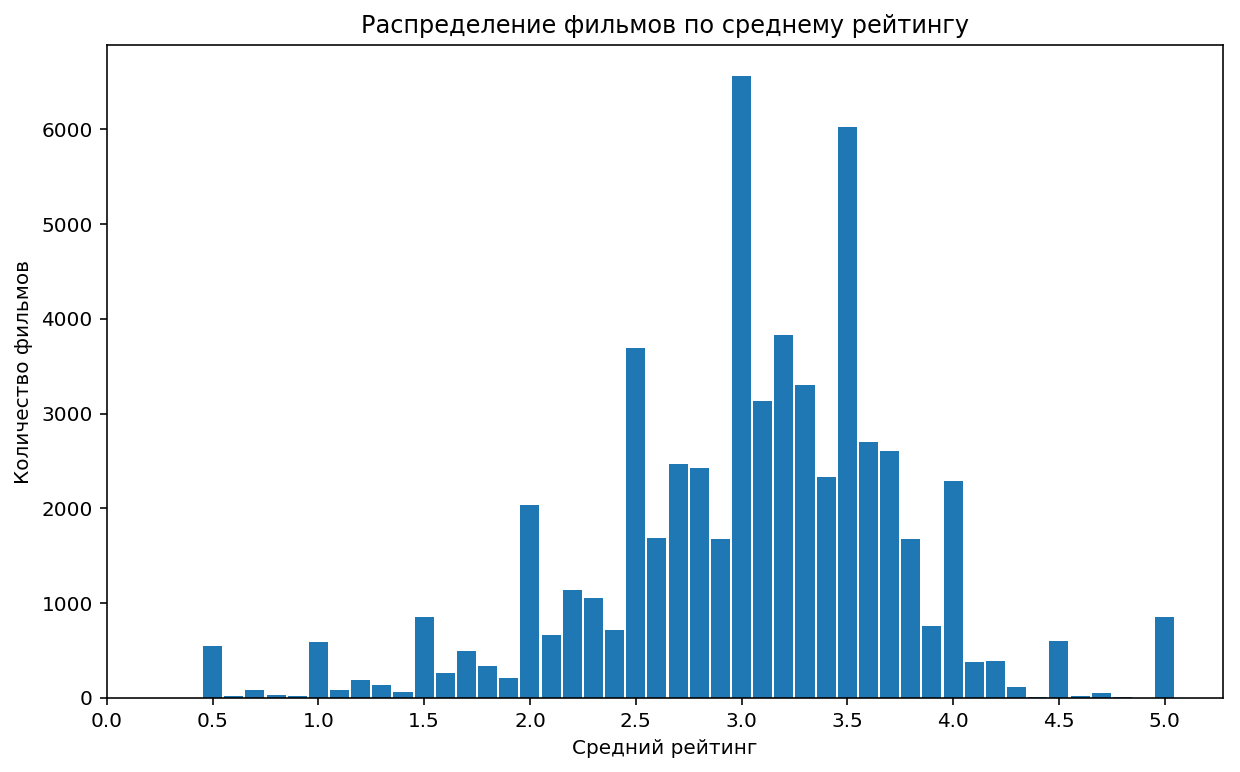

In [64]:
keys, values = zip(*[(1/10 * r, cnt) for r, cnt in hist_movie_avg])

f, ax = plt.subplots(figsize=(10, 6))
plt.bar(keys, values, width=0.09, align="center")
ax.set_xticks([0.5 * i for i in range(11)])
plt.title('Распределение фильмов по среднему рейтингу')
plt.xlabel('Средний рейтинг')
plt.ylabel('Количество фильмов')
plt.show()

### Распределение числа оценок для фильмов

Построить распределение фильмов по числу оценок

In [88]:
rating_cnt = ratings \
            .map(lambda r: (r.movie_id, 1)) \
            .reduceByKey(lambda a, b: a + b) \
            .map(lambda r: (int(r[1] / 1000), 1)) \
            .reduceByKey(lambda a, b: a + b) \
            .collect()

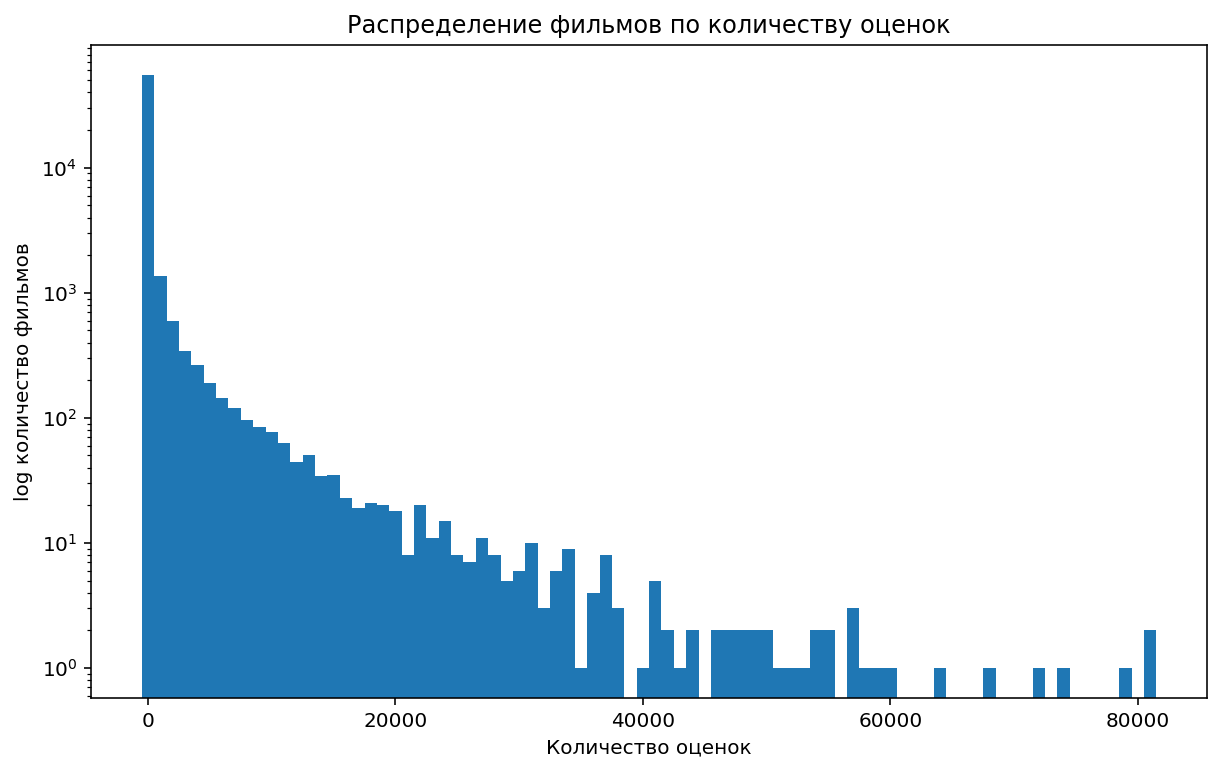

In [90]:
keys, values = zip(*[(1000*r, cnt) for r, cnt in rating_cnt])

f, ax = plt.subplots(figsize=(10, 6))
plt.bar(keys, values, width=1000, log=True)
plt.title('Распределение фильмов по количеству оценок')
plt.xlabel('Количество оценок')
plt.ylabel('log количество фильмов')
plt.show()

### Распределение фильмов по жанрам

Построить гистограмму распределения фильмов по жанрам. Обратите внимание, что у фильма может быть указано больше одного жанра.

In [115]:
movies = sc.textFile(MOVIES_PATH)

genres = movies \
            .map(lambda s: s.split(',')) \
            .filter(lambda row: row[0].isdigit())\
            .flatMap(lambda key: key[-1].split('|')) \
            .map(lambda g: (g, 1)) \
            .reduceByKey(lambda a, b: a + b) \
            .collect()

genres = sorted(genres, key=lambda a: a[1], reverse=True)
genres

[('Drama', 25606),
 ('Comedy', 16870),
 ('Thriller', 8654),
 ('Romance', 7719),
 ('Action', 7348),
 ('Horror', 5989),
 ('Documentary', 5605),
 ('Crime', 5319),
 ('(no genres listed)', 5062),
 ('Adventure', 4145),
 ('Sci-Fi', 3595),
 ('Children', 2935),
 ('Animation', 2929),
 ('Mystery', 2925),
 ('Fantasy', 2731),
 ('War', 1874),
 ('Western', 1399),
 ('Musical', 1054),
 ('Film-Noir', 353),
 ('IMAX', 195)]

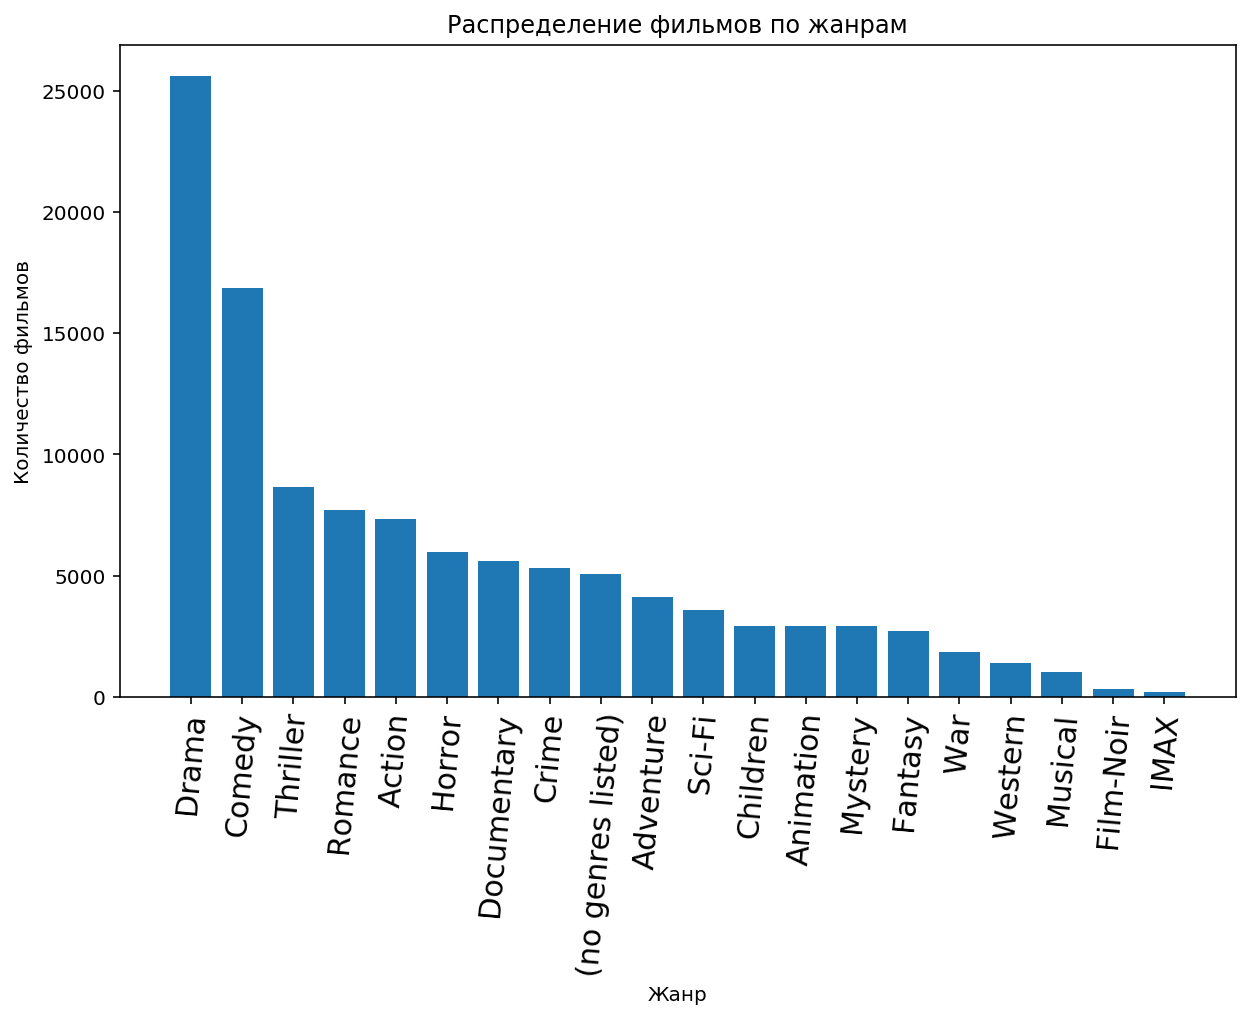

In [113]:
keys, values = zip(*genres)

f, ax = plt.subplots(figsize=(10, 6))
plt.bar(keys, values)
plt.xticks(rotation=85, fontsize=15)
plt.title('Распределение фильмов по жанрам')
plt.xlabel('Жанр')
plt.ylabel('Количество фильмов')
plt.show()

### Актеры

Для решения задач ниже нужно воспользоваться файлами `ratings.csv`, `movies.csv`, `links.csv` и `tmdb.json`.

* `links.csv` - задает отображение из `movie_id` в `tmdb_movie_id` (подробное описание в `ml-25m-README.htm`)
* `tmdb.json` - содержит большое количество данных о фильмах в формате json (на каждой строчке отдельный json)

Задачи

1. Найти все фильмы, в которых играл `"id":31, "name":"Tom Hanks"`
2. Найти 10 актеров снявшихся в наибольшем числе фильмов. Вывести их имена и кол-во фильмов, в которых они снимались

In [20]:
import json
TMDB_PATH = os.path.join(DATA_PATH, 'tmdb.json')

In [36]:
tmdb = sc.textFile(TMDB_PATH)

tmdb = tmdb \
        .map(lambda s: json.loads(s)) \
        .filter(lambda s: 'id' in s) 

In [156]:
movies_actors = tmdb \
    .map(lambda s: (s['id'], s['title'], s['casts']['cast'])) \
    .flatMap(lambda s: [(cast, s[1], s[0]) for cast in s[2]])

In [157]:
movies_actors.take(1)

[({'cast_id': 14,
   'character': 'Woody (voice)',
   'credit_id': '52fe4284c3a36847f8024f95',
   'gender': 2,
   'id': 31,
   'name': 'Tom Hanks',
   'order': 0,
   'profile_path': '/xxPMucou2wRDxLrud8i2D4dsywh.jpg'},
  'Toy Story',
  862)]

In [158]:
movies_Tom_Hanks = movies_actors \
    .filter(lambda s: s[0]['id'] == 31 and s[0]['name'] == 'Tom Hanks') \
    .map(lambda s: s[1]) \
    .collect()

In [159]:
print('Total number of movies:', len(movies_Tom_Hanks), end='\n\n')
print(movies_Tom_Hanks)

Total number of movies: 76

['Toy Story', 'Apollo 13', 'Forrest Gump', 'Philadelphia', 'Sleepless in Seattle', 'The Celluloid Closet', 'That Thing You Do!', 'Saving Private Ryan', "The 'Burbs", 'Splash', 'The Money Pit', 'Nothing in Common', "You've Got Mail", 'Big', 'Return with Honor', 'Toy Story 2', 'The Bonfire of the Vanities', 'The Green Mile', 'A League of Their Own', 'Volunteers', 'Bachelor Party', 'Punchline', 'Cast Away', 'Turner & Hooch', "He Knows You're Alone", 'Joe Versus the Volcano', 'Road to Perdition', 'Catch Me If You Can', 'Radio Flyer', 'Dragnet', 'The Ladykillers', 'The Terminal', 'The Man with One Red Shoe', 'The Polar Express', 'The Da Vinci Code', 'Cars', 'The Simpsons Movie', "Charlie Wilson's War", 'The Great Buck Howard', 'Angels & Demons', 'Shooting War', 'Toy Story 3', 'The Pixar Story', 'Larry Crowne', 'Extremely Loud & Incredibly Close', 'Beyond All Boundaries', 'Cloud Atlas', 'Captain Phillips', 'Toy Story of Terror!', 'Saving Mr. Banks', 'Killing Linco

In [163]:
top_10 = movies_actors \
            .map(lambda actor: (actor[0]['id'], (actor[0]['name'], 1))) \
            .reduceByKey(lambda a, b: (a[0], a[1] + b[1])) \
            .sortBy(lambda key: key[1][1], ascending=False) \
            .map(lambda s: s[1])

top_10 = top_10.take(10)

In [175]:
for actor, cnt in top_10:
    print('%17s:  %4s' % (actor, cnt))

     Bess Flowers:   380
     Frank Welker:   184
  Christopher Lee:   175
    Clarence Nash:   158
     Irving Bacon:   152
   John Carradine:   146
       John Wayne:   142
        Mel Blanc:   140
Samuel L. Jackson:   134
     Eric Roberts:   130


### Доля жанра в течении времени

Для каждого жанра нужно построить как менялась доля вышедших фильмов данного жанра относительно всех остальных жанров.

Дату выхода фильма можно взять из файла `tmdb.json`.

(См. `plt.stackplot`)

In [74]:
import numpy as np

In [69]:
genres_year = tmdb \
    .filter(lambda m: 'release_date' in m) \
    .flatMap(lambda m: [((m['release_date'][:4], genre['name']), 1) for genre in m['genres']]) \
    .filter(lambda row: row[0][0] != '') \
    .map(lambda row: ((int(row[0][0]), row[0][1]), row[1])) \
    .reduceByKey(lambda a,b: a + b) \
    .map(lambda row: (row[0][0], row[0][1], row[1])) \
    .collect()


In [80]:
year, g, cnt = zip(*genres_year)
total_years = np.unique(year)
total_genres = np.unique(g)
total_genres

array(['Action', 'Adventure', 'Animation', 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Family', 'Fantasy', 'History', 'Horror',
       'Music', 'Mystery', 'Romance', 'Science Fiction', 'TV Movie',
       'Thriller', 'War', 'Western'], dtype='<U15')

In [86]:
year_cnt = {y: 0 for y in total_years}
genre_num = {g: i for i, g in enumerate(total_genres)}
year_num = {y: i for i, y in enumerate(total_years)}

for year, g, cnt in genres_year:
    year_cnt[year] += cnt

ratios = np.zeros((len(total_genres), len(total_years)))

for year, g, cnt in genres_year:
    i = genre_num[g]
    j = year_num[year]
    ratios[i,j] = cnt / year_cnt[year]
    

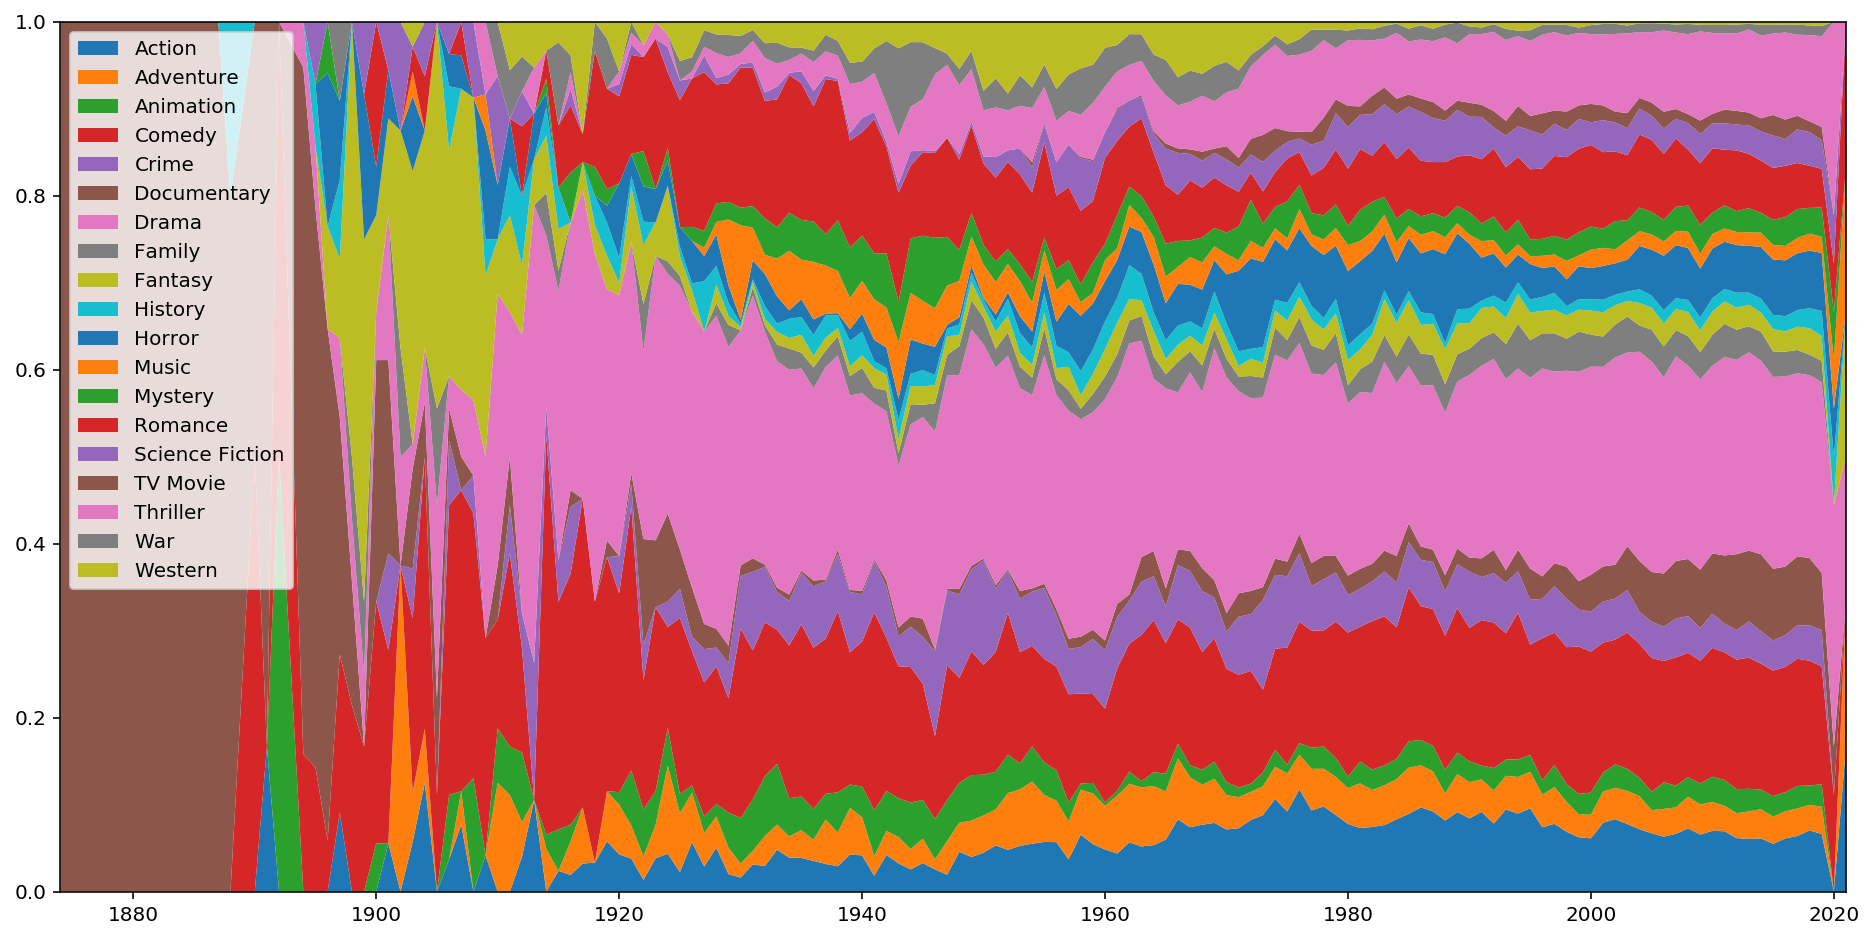

In [90]:
plt.figure(figsize=(16, 8))

plt.stackplot(total_years, ratios, labels=total_genres)
plt.legend(loc='upper left')
plt.xlim(total_years[0], total_years[-1])
plt.ylim(0, 1)
plt.show()

### Окупаемость фильмов

Для каждого жанра посчитать `ROI = mean(revenue) / mean(budget)` и построить `barplot`, где по оси x будет название жанра, а по оси y - `ROI`

Данные о `revenue` и `budget` можно найти в файле `tmdb.json`.

In [104]:
roi = tmdb \
    .filter(lambda row: row['genres']) \
    .flatMap(lambda row: [(g['name'], (row['revenue'], row['budget'])) for g in row['genres']]) \
    .reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1])) \
    .map(lambda row: (row[0], row[1][0] / row[1][1])) \
    .collect()

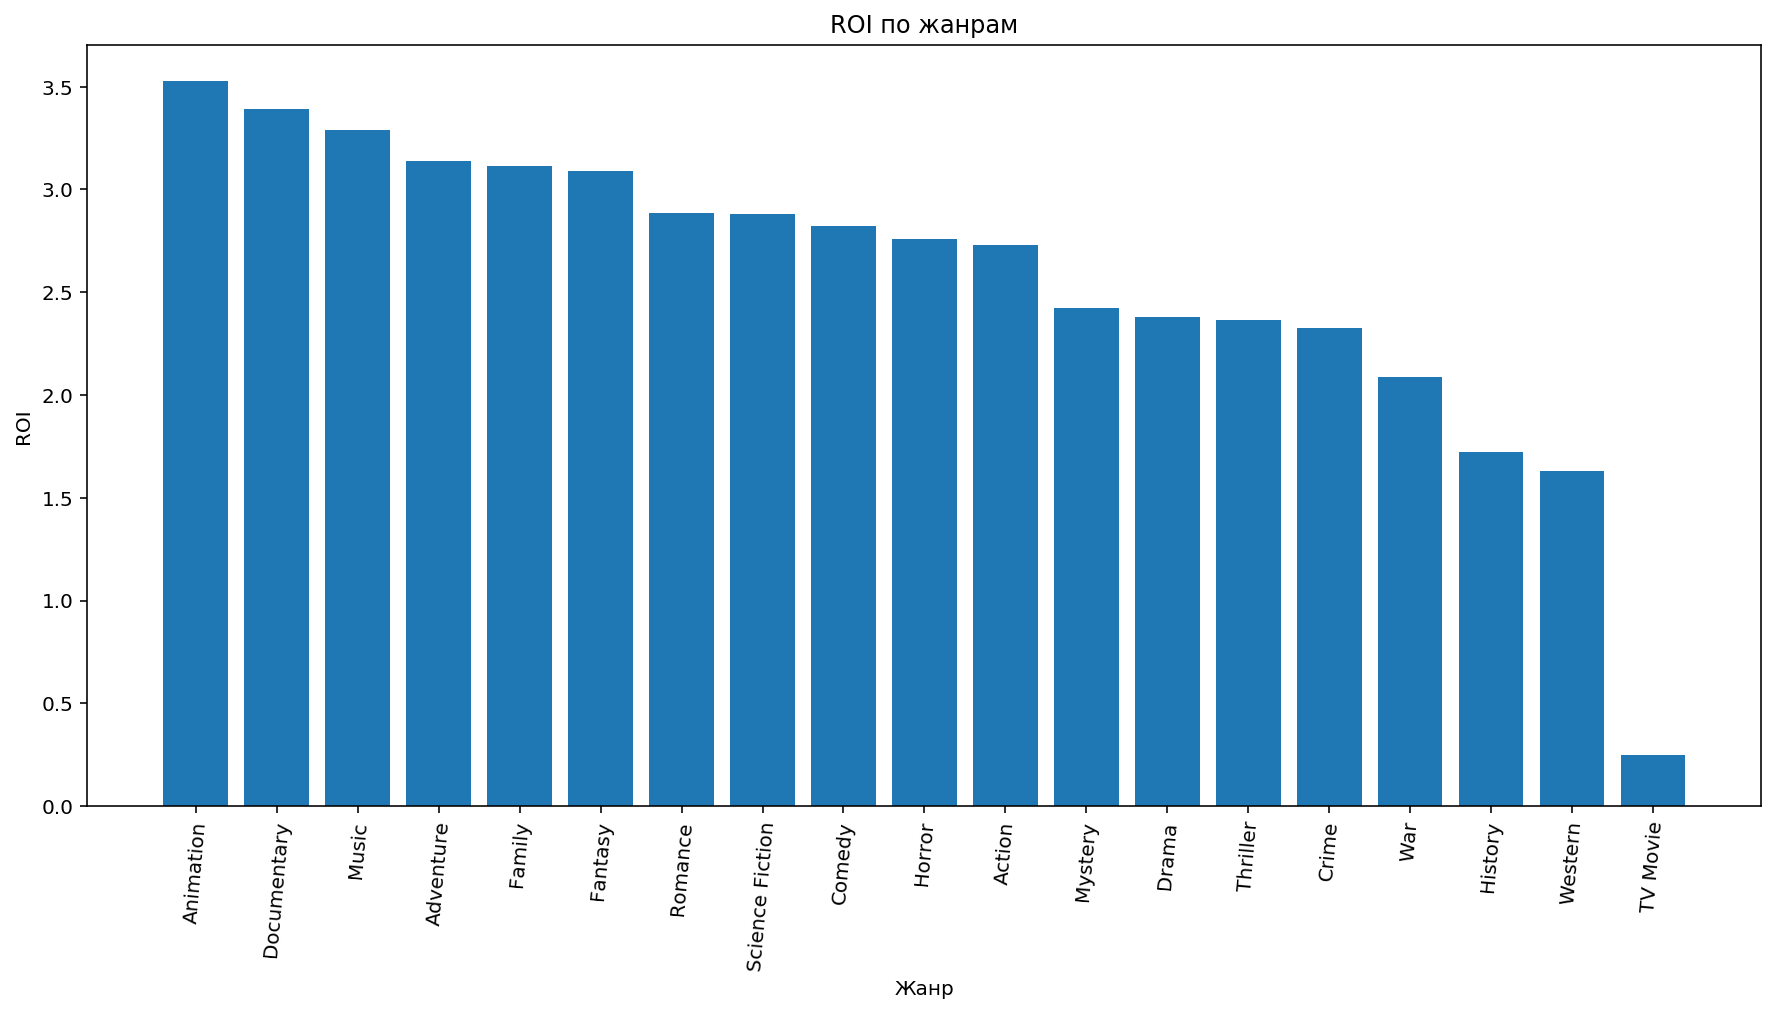

In [108]:
roi = sorted(roi, key=lambda key: key[-1], reverse=True)
g, value = zip(*roi)

plt.figure(figsize=(15, 7))
plt.title('ROI по жанрам')
plt.bar(g, value)
plt.xticks(rotation=85)
plt.xlabel('Жанр')
plt.ylabel('ROI')
plt.show()